In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler,OneHotEncoder # шкалирование данных, нормализация

from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Загрузить датасет

In [2]:
# https://www.kaggle.com/competitions/playground-series-s3e12/data
test_df = pd.read_csv('dataset/test.csv')
train_df = pd.read_csv('dataset/train.csv')

# 2. EDA датасета

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


Описание свойств:
* graviti - удельный вес, плотность мочи по отношению к воде;
* pH - рН, отрицательный логарифм иона водорода
* osmo - осмолярность (mOsm) - единица измерения, используемая в биологии и медицине, но не в физической химии. 
Осмолярность пропорциональна концентрации молекул в растворе.
* cond - электропроводность (mMho, миллимехо). Один Mho равен одному обратному Ому. 
Электропроводность пропорциональна концентрации заряженных ионов в растворе;
* urea - концентрация мочевины в миллимолях на литр
* calc - концентрация кальция (CALC) в миллиметровом литре.
* target - целевая переменная

In [4]:
train_df.sample(10)

,id,gravity,ph,osmo,cond,urea,calc,target
346,346,1.021,5.71,760,25.7,199,2.33,0
114,114,1.007,6.88,242,10.9,14,0.65,1
81,81,1.014,6.14,565,23.6,214,2.45,0
322,322,1.021,5.71,779,21.4,382,4.18,1
280,280,1.022,7.20,721,20.6,385,9.39,1
57,57,1.021,5.35,774,23.6,301,6.99,1
133,133,1.020,5.53,781,26.0,349,3.46,0
244,244,1.012,5.53,410,13.4,195,1.53,0
24,24,1.021,6.29,725,19.7,443,2.45,1
124,124,1.017,6.13,594,33.6,224,3.01,0


In [5]:
def percent_value(df, value):
    """Посчитать долю значения value в df"""
    if np.isnan(value):
        return [(len(df[df[column].isna()]) / len(df)) * 100 for column in df.columns]
    else:
        return [(len(df[df[column]==value]) / len(df)) * 100 for column in df.columns]
    
def eda_df(df):
    """Провести EDA для датафрейма"""
    df_describe = df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    # посчитать долю пропусков
    df_describe.loc["%nan"] = percent_value(df, np.nan)
    # посчитать дисперсию
    columns_var = []
    for column in df_describe.columns:
        columns_var.append(df[column].var())
    df_describe.loc['var'] = columns_var
    return df_describe

In [6]:
train_df_describe = eda_df(train_df)
train_df_describe

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
10%,41.300000,1.008000,5.330000,343.600000,10.900000,95.000000,1.053000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
90%,371.700000,1.025000,6.810000,925.200000,29.000000,443.000000,8.515000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


In [7]:
test_df_describe = eda_df(test_df)
test_df_describe

,id,gravity,ph,osmo,cond,urea,calc
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,551.500000,1.018330,5.939312,654.891304,21.886594,280.985507,4.076848
std,79.818544,0.006569,0.607143,236.361932,7.346069,134.877856,3.088524
min,414.000000,1.005000,4.900000,187.000000,5.100000,64.000000,0.170000
10%,441.500000,1.009000,5.350000,364.000000,11.200000,95.000000,1.110000
25%,482.750000,1.014000,5.530000,456.000000,17.400000,168.500000,1.527500
50%,551.500000,1.019000,5.730000,658.000000,23.600000,282.000000,3.230000
75%,620.250000,1.023250,6.210000,843.250000,27.600000,385.000000,5.540000
90%,661.500000,1.026000,6.800000,947.000000,29.500000,457.000000,8.480000
max,689.000000,1.034000,7.940000,1236.000000,38.000000,620.000000,14.340000


# 3. Доли значений целевой переменной

In [8]:
# посчитать долю пропусков
#percent_value = lambda df, value: df[df["target"]==value]["target"].sum() * 100 / len(df)
percent_one_value = percent_value(train_df[["target"]], 1)
percent_zero_value = percent_value(train_df[["target"]], 0)
print(f"Доля значения 1: {percent_one_value[0]}, Доля значения 0: {percent_zero_value[0]}")

Доля значения 1: 44.44444444444444, Доля значения 0: 55.55555555555556


# 4. Графики для анализа

In [29]:
fig = px.imshow(train_df.corr(), height=600, width=600, text_auto='.2f' )
fig.show()

In [35]:
fig = make_subplots(rows=2, cols=2)
fig.update_layout(
    title_x=0.5,
    title_text="Зависимости переменных",
    height=1000, 
    width=1200
)
fig.add_scatter(x = train_df["urea"], y = train_df["osmo"], mode='markers', name="urea - osmo", row=1, col=1)
fig.add_scatter(x = train_df["gravity"], y = train_df["osmo"], mode='markers', name="gravity - osmo", row=1, col=2)
fig.add_scatter(x = train_df["cond"], y = train_df["osmo"], mode='markers', name="cond - osmo", row=2, col=1)
fig.add_scatter(x = train_df["calc"], y = train_df["osmo"], mode='markers', name="calc - osmo", row=2, col=2)

fig.show()

In [33]:
fig = make_subplots(rows=2, cols=3)
fig.update_layout(
    title_x=0.5,
    title_text="Ящики с усами",
    height=1000, 
    width=1200
)

fig.add_box(y=train_df["urea"], name="urea", row=1, col=1)
fig.add_box(y=train_df["gravity"], name="gravity", row=1, col=2)
fig.add_box(y=train_df["osmo"], name="osmo", row=1, col=3)
fig.add_box(y=train_df["calc"], name="calc", row=2, col=1)
fig.add_box(y=train_df["cond"], name="cond", row=2, col=2)
fig.add_box(y=train_df["ph"], name="ph", row=2, col=3)
fig.show()

# 5. KNN

In [12]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(train_df[["gravity", "ph", "osmo", "cond", "urea", "calc"]],
                                                    train_df["target"],
                                                    stratify=train_df["target"],
                                                    test_size=0.2, random_state=42)

In [13]:
X_train.shape,  X_test.shape

((331, 6), (83, 6))

In [14]:
y_train.mean(), y_test.mean()

(np.float64(0.44410876132930516), np.float64(0.4457831325301205))

In [15]:
param_grid = {'n_neighbors': range(1, 21, 5),
              'p': [1, 2]}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21, 5), 'p': [1, 2]},
             scoring='roc_auc')

In [16]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001495,0.000800,0.001818,0.000406,1,1,"{'n_neighbors': 1, 'p': 1}",0.640991,0.579217,0.515377,0.606244,0.552778,0.578922,0.043175,7
1,0.001110,0.000095,0.001627,0.000107,1,2,"{'n_neighbors': 1, 'p': 2}",0.640991,0.558248,0.542404,0.565704,0.538889,0.569247,0.037210,8
2,0.001072,0.000011,0.001672,0.000030,6,1,"{'n_neighbors': 6, 'p': 1}",0.737387,0.708760,0.556850,0.660764,0.633333,0.659419,0.062795,1
3,0.001015,0.000020,0.001596,0.000061,6,2,"{'n_neighbors': 6, 'p': 2}",0.726577,0.737185,0.522367,0.683131,0.584259,0.650704,0.083872,3
4,0.001049,0.000045,0.001696,0.000079,11,1,"{'n_neighbors': 11, 'p': 1}",0.680180,0.718080,0.597856,0.646785,0.622685,0.653117,0.042362,2
5,0.001028,0.000010,0.001637,0.000023,11,2,"{'n_neighbors': 11, 'p': 2}",0.666216,0.684063,0.562442,0.654706,0.583333,0.630152,0.048139,6
6,0.001043,0.000045,0.001735,0.000030,16,1,"{'n_neighbors': 16, 'p': 1}",0.665766,0.676142,0.588537,0.680801,0.581019,0.638453,0.044159,4
7,0.001061,0.000040,0.001765,0.000099,16,2,"{'n_neighbors': 16, 'p': 2}",0.690090,0.696645,0.572227,0.649115,0.570833,0.635782,0.054934,5


In [17]:
grid_search.best_params_

{'n_neighbors': 6, 'p': 1}

In [18]:
knn_best = KNeighborsClassifier(**grid_search.best_params_)
#knn_best = KNeighborsClassifier(n_neighbors = 6, p = 1)

In [19]:
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6, p=1)

In [20]:
n_neighbors=10
model_cl = KNeighborsClassifier(n_neighbors = n_neighbors)
model_cl.fit(X_train, y_train) # тренировка модели fit

KNeighborsClassifier(n_neighbors=10)

In [21]:
y_test_pred = knn_best.predict(X_test)
y_test_prob = knn_best.predict_proba(X_test)[:, 1]

y_train_pred = knn_best.predict(X_train)
y_train_prob = knn_best.predict_proba(X_train)[:, 1]

In [22]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix Test:")
print(conf_matrix)

conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix Train:")
print(conf_matrix)

Confusion Matrix Test:
[[36 10]
 [24 13]]
Confusion Matrix Train:
[[159  25]
 [ 64  83]]


In [23]:
# Accuracy

print("Accuracy:", accuracy_score(y_test, y_test_pred), accuracy_score(y_train, y_train_pred))

# Precision
print("Precision:", precision_score(y_test, y_test_pred), precision_score(y_train, y_train_pred))

# Recall
print("Recall:", recall_score(y_test, y_test_pred), recall_score(y_train, y_train_pred))


Accuracy: 0.5903614457831325 0.7311178247734139
Precision: 0.5652173913043478 0.7685185185185185
Recall: 0.35135135135135137 0.564625850340136


In [24]:
# AUC ROC
print("AUC ROC:", roc_auc_score(y_train, y_train_prob), roc_auc_score(y_test, y_test_prob))

AUC ROC: 0.8118160307601301 0.6239717978848414


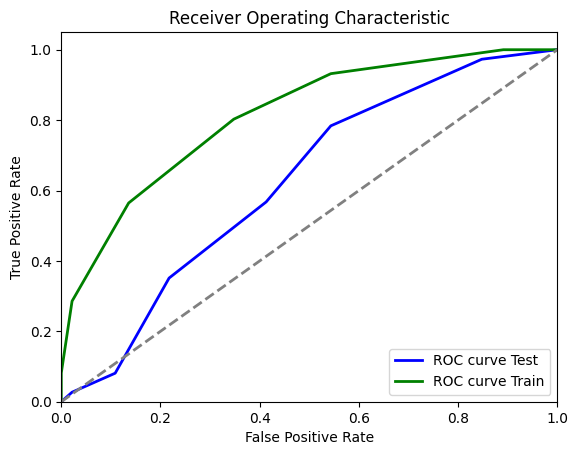

In [25]:
import matplotlib.pyplot as plt
# Построение ROC кривой
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve Test')

fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve Train')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()